# Ridge Regularization (L2 Regularization)

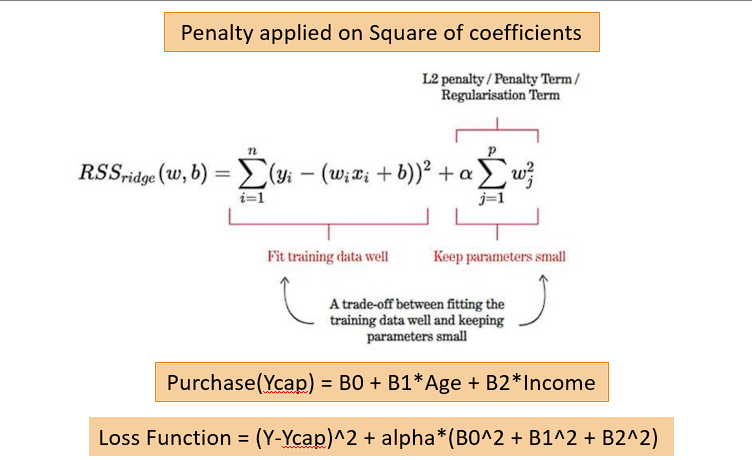

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

### Weight(Y) ~ Remaining features

In [2]:
import pandas as pd
df = pd.read_csv('Cars93.csv', na_values=['', 'NA'], keep_default_na=False)
df.head()

,id,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin,Make
0,1,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,...,5,177,102,68,37,26.5,11.0,2705,non-USA,Acura Integra
1,2,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,...,5,195,115,71,38,30.0,15.0,3560,non-USA,Acura Legend
2,3,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,...,5,180,102,67,37,28.0,14.0,3375,non-USA,Audi 90
3,4,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,...,6,193,106,70,37,31.0,17.0,3405,non-USA,Audi 100
4,5,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,...,4,186,109,69,39,27.0,13.0,3640,non-USA,BMW 535i


### Check basic data quality 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  93 non-null     int64  
 1   Manufacturer        93 non-null     object 
 2   Model               93 non-null     object 
 3   Type                93 non-null     object 
 4   Min.Price           93 non-null     float64
 5   Price               93 non-null     float64
 6   Max.Price           93 non-null     float64
 7   MPG.city            93 non-null     int64  
 8   MPG.highway         93 non-null     int64  
 9   AirBags             89 non-null     object 
 10  DriveTrain          93 non-null     object 
 11  Cylinders           93 non-null     object 
 12  EngineSize          93 non-null     float64
 13  Horsepower          93 non-null     int64  
 14  RPM                 93 non-null     int64  
 15  Rev.per.mile        93 non-null     int64  
 16  Man.trans.

In [4]:
m = df.isna().sum()
m

id                     0
Manufacturer           0
Model                  0
Type                   0
Min.Price              0
Price                  0
Max.Price              0
MPG.city               0
MPG.highway            0
AirBags                4
DriveTrain             0
Cylinders              0
EngineSize             0
Horsepower             0
RPM                    0
Rev.per.mile           0
Man.trans.avail        0
Fuel.tank.capacity     0
Passengers             0
Length                 0
Wheelbase              0
Width                  0
Turn.circle            0
Rear.seat.room         2
Luggage.room          11
Weight                 0
Origin                 0
Make                   0
dtype: int64

In [5]:
m[m>0]

AirBags            4
Rear.seat.room     2
Luggage.room      11
dtype: int64

In [6]:
df.duplicated().sum()

0

### Seperate X and Y(Weight)

In [7]:
X = df.drop(columns=['id', 'Weight'])
Y = df[['Weight']]

In [8]:
X.head()

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make
0,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,Front,...,13.2,5,177,102,68,37,26.5,11.0,non-USA,Acura Integra
1,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,...,18.0,5,195,115,71,38,30.0,15.0,non-USA,Acura Legend
2,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,Front,...,16.9,5,180,102,67,37,28.0,14.0,non-USA,Audi 90
3,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,21.1,6,193,106,70,37,31.0,17.0,non-USA,Audi 100
4,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,...,21.1,4,186,109,69,39,27.0,13.0,non-USA,BMW 535i


In [9]:
Y.head()

,Weight
0,2705
1,3560
2,3375
3,3405
4,3640


### Seperte categorical and continuous features for X

In [10]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [11]:
cat

['Manufacturer',
 'Model',
 'Type',
 'AirBags',
 'DriveTrain',
 'Cylinders',
 'Man.trans.avail',
 'Origin',
 'Make']

In [12]:
con

['Min.Price',
 'Price',
 'Max.Price',
 'MPG.city',
 'MPG.highway',
 'EngineSize',
 'Horsepower',
 'RPM',
 'Rev.per.mile',
 'Fuel.tank.capacity',
 'Passengers',
 'Length',
 'Wheelbase',
 'Width',
 'Turn.circle',
 'Rear.seat.room',
 'Luggage.room']

### Preprocess X data with Pipeline

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [14]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                           ('scaler', StandardScaler())])

In [15]:
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [16]:
pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [17]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Min.Price', 'Price', 'Max.Price', 'MPG.city',
                                  'MPG.highway', 'EngineSize', 'Horsepower',
                                  'RPM', 'Rev.per.mile', 'Fuel.tank.capacity',
                                  'Passengers', 'Length', 'Wheelbase', 'Width',
                                  'Turn.circle', 'Rear.seat.room',
                                  'Luggage.room']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Manufacturer', 'Model', 'Type', 'AirBags',
                                  'DriveTrain', 'Cylinders', 'Man.trans.avail',
                                  'Origin', 'Make'])])

In [18]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,cat__Make_Toyota Camry,cat__Make_Toyota Celica,cat__Make_Toyota Previa,cat__Make_Toyota Tercel,cat__Make_Volkswagen Corrado,cat__Make_Volkswagen Eurovan,cat__Make_Volkswagen Fox,cat__Make_Volkswagen Passat,cat__Make_Volvo 240,cat__Make_Volvo 850
0,-0.485787,-0.375720,-0.282465,0.471312,0.360925,-0.841022,-0.073484,1.717489,1.129530,-1.062184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.388017,1.497844,1.531409,-0.781032,-0.770514,0.515869,1.078322,0.369586,0.005661,0.409445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.008658,0.998227,0.948052,-0.423219,-0.581941,0.128186,0.540813,0.369586,-0.105713,0.072197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.571949,1.893374,2.069191,-0.602126,-0.581941,0.128186,0.540813,0.369586,0.410659,1.359872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.755752,1.091905,1.303535,-0.065407,0.172352,0.806631,1.231897,0.706562,0.430909,1.359872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train test split
30% data is test data and will be unseen to the model

In [19]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.3,
                                                random_state=21)

In [20]:
xtrain.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,cat__Make_Toyota Camry,cat__Make_Toyota Celica,cat__Make_Toyota Previa,cat__Make_Toyota Tercel,cat__Make_Volkswagen Corrado,cat__Make_Volkswagen Eurovan,cat__Make_Volkswagen Fox,cat__Make_Volkswagen Passat,cat__Make_Volvo 240,cat__Make_Volvo 850
68,-0.336343,-0.334085,-0.318925,0.113500,0.360925,-0.453339,-0.649388,-0.135877,0.471409,-0.050439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,-0.991600,-0.635937,-0.328040,0.471312,1.303790,-0.453339,-0.649388,-0.135877,0.096786,-0.449005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,-0.658223,-0.531850,-0.410075,0.113500,0.172352,-0.841022,-0.994930,-0.472853,0.056286,-0.234393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,-0.600745,-0.646346,-0.656178,-0.065407,-0.393368,-0.162577,-0.841356,-0.809828,0.410659,-0.203734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,-0.324847,-0.313268,-0.291580,0.650219,0.926644,-0.162577,0.387238,0.538074,0.349909,-0.357028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
ytrain.head()

,Weight
68,2890
11,2490
71,2640
24,2970
54,2970


In [22]:
xtest.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,cat__Make_Toyota Camry,cat__Make_Toyota Celica,cat__Make_Toyota Previa,cat__Make_Toyota Tercel,cat__Make_Volkswagen Corrado,cat__Make_Volkswagen Eurovan,cat__Make_Volkswagen Fox,cat__Make_Volkswagen Passat,cat__Make_Volvo 240,cat__Make_Volvo 850
23,-1.003095,-0.854520,-0.701753,0.113500,-0.016221,-0.453339,-0.975733,-0.809828,0.532158,-0.816912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,0.203957,0.332071,0.428500,-0.781032,-1.336233,-0.259498,-0.111878,-0.472853,0.370159,0.961306,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,0.537333,0.332071,0.145937,-0.244313,-0.204794,-0.356418,-0.572601,0.201098,-0.237337,-0.265051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21,1.422504,1.039862,0.692834,-0.423219,-0.581941,0.612789,0.060893,-0.809828,-1.108083,-0.203734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.100495,-0.073868,-0.209546,-0.959938,-0.581941,2.260442,0.502419,-1.820755,-1.988953,1.942392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
ytest.head()

,Weight
23,2670
86,3785
91,2985
21,3570
17,3910


In [24]:
xtrain.shape

(65, 257)

In [25]:
xtest.shape

(28, 257)

### Create a linear regression model

In [26]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(xtrain, ytrain)

LinearRegression()

In [27]:
model1.score(xtrain, ytrain)

1.0

In [28]:
model1.score(xtest, ytest)

0.9176614252317222

### Create a ridge model

In [29]:
from sklearn.linear_model import Ridge
model2 = Ridge(alpha=2)
model2.fit(xtrain, ytrain)

Ridge(alpha=2)

In [30]:
model2.score(xtrain, ytrain)

0.9949332990432137

In [31]:
model2.score(xtest, ytest)

0.9253346382420654

### Hyperparameter tuning

In [32]:
import numpy as np 
alphas = np.arange(start=0.1, stop=100, step=0.1)
alphas

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. ,
       11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1,
       12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1, 13.2,
       13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2, 14.3,
       14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15

In [33]:
params = {'alpha':alphas}
params

{'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
         1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
         2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
         3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
         4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
         5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
         6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
         7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
         8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
        10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. ,
        11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1,
        12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1, 13.2,
        13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2, 14.3,
        14.4, 14.5, 14.6, 14.

In [34]:
from sklearn.model_selection import GridSearchCV
rr = Ridge()
gscv = GridSearchCV(estimator=rr, param_grid=params, cv=5, 
                    scoring='neg_mean_squared_error')
gscv.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7....
       93.6, 93.7, 93.8, 93.9, 94. , 94.1, 94.2, 94.3, 94.4, 94.5, 94.6,
       94.7, 94.8, 94.9, 95. , 95.1, 95.2, 95.3, 95.4, 95.5, 95.6, 95.7,
       95.8, 95.9, 96. , 96.1, 96.2, 96.3, 96.4, 96.5, 96.6, 96.7, 96.8,
       96.9, 97. , 97.1, 97.2, 97.3, 97.4, 97.5, 97.6, 97.7, 97.8, 97.9,
       98. , 98.1, 98.2, 98.3, 98.4, 98.5, 98.6, 98.7, 98.8, 98.9, 99. ,
       99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9])},
             scoring='neg_mean_squared_error')

In [35]:
gscv.best_params_

{'alpha': 1.3000000000000003}

In [36]:
gscv.best_score_

-20785.225021389422

In [37]:
best_ridge = gscv.best_estimator_
best_ridge

Ridge(alpha=1.3000000000000003)

### Evaluate tuned model

In [38]:
best_ridge.score(xtrain, ytrain)

0.9970992859739819

In [39]:
best_ridge.score(xtest, ytest)

0.9230888084110538

### Cross validated r2 for above model

In [42]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_ridge, xtrain, ytrain, cv=5, scoring='r2')
scores

array([0.88315879, 0.96447621, 0.9709034 , 0.89321598, 0.91354488])

In [43]:
scores.mean()

0.9250598515906093